In [5]:
import logging
import pandas as pd
import numpy as np
import jieba
import random
from gensim.models import word2vec

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from sklearn.metrics import accuracy_score

# w2v

## non split data

In [6]:
# Loading dataset
train = pd.read_csv('train.csv')
train
val = pd.read_csv('validation.csv')
val

,Content,Label
0,我有個國小認識的好朋友，上了大學後常常會跟我訴苦，大多是關於人際關係的他個性比較內向，不容易...,0
1,(第一人稱視角，)媽媽跟爸爸從我出生就感情不好 所以國小時離婚了我喜歡媽媽 不喜歡爸爸但我們...,1
2,我的前任在自殺前一周突然幫我慶生，一天前找我出門玩，再一聲不吭的自我了斷，給我很大的陰影。現...,0
3,身為一個亞斯伯格症的人看到這則新聞還蠻難過的首先我可以理解家長看到自己小孩無緣無故被攻擊而想...,0
4,真的很長，防雷。26個年頭來，經歷了大小事情。媽媽在國小開始因為經濟不景氣、收店的壓力、被朋...,0
...,...,...
249,我是1995年出生，我妹則是1999年出生，過去這兩年我們家歷經了非常嚴重的衝突。我和我妹都...,0
250,我有個水瓶男好朋友他會跟我說相處自在點他都是想怎樣就怎樣很隨性我也有點這樣所以我們才能成為好...,0
251,如題小時候我真的是活在陰影下...從我有印象第一次被打的那時候開始講吧！那時我才國中一年級 ...,0
252,如標題我現在已經滿20了，我家在北部但是在外縣市讀書當初高中填志願的時候就是為了逃離我媽才把...,0


In [14]:
## 取200筆非自殺
# train_neg = train[train["Label"] == 0].iloc[:200]
# train_pos = train[train["Label"] == 1]
# train = pd.concat([train_neg,train_pos])
# train = train.reset_index(drop=True)
# train

,Content,Label
0,仙草加蜂蜜好好吃！等下再去市場買一塊大仙草~吃吃吃好像把今天的熱量扣打吃完了-----Sen...,0
1,啊啊啊 邁入老女人的里程碑了今天本來想請假的但被同事搶先了然後從禮拜六開始爸爸媽媽就滿滿的情...,0
2,今天同事提出，覺得我有點過度依賴男友了不是第一個人說出這個問題其實早在交往的一開始我自己就察...,0
3,開始停速悅的這幾天我還是會吃安立平總覺得現在除了心悸手抖頭很重以外一直還有個在耳邊敲打小軍鼓...,0
4,我覺得有些善意的謊言是可以說的就是那些不會被揭穿的但有一些是一定會被揭穿「你狀態不好的時侯可...,0
...,...,...
298,很想一走了之。從人生這場遊戲登出。去年以前，厭食了6年去年開始暴食。或許我恨的是自己所以什麼...,1
299,要嘛給我愛，要嘛給我錢，要嘛給我滾。其實你連當炮友的資格都沒有，憑什麼跟我談戀愛？無法給我愛...,1
300,以為可以好一陣子不用上來發文了生命又再次賞我好一大巴掌我真的真的真的很努力很努力了我為甚麼總...,1
301,從四年前，一直都有失眠的小問題，但都是以作息不正常來解套自己的想法。前年二月到六月，我的狀況...,1


## Split Data

In [7]:
total = pd.concat([train, val])
total = total.reset_index(drop=True)
total

,Content,Label
0,仙草加蜂蜜好好吃！等下再去市場買一塊大仙草~吃吃吃好像把今天的熱量扣打吃完了-----Sen...,0
1,啊啊啊 邁入老女人的里程碑了今天本來想請假的但被同事搶先了然後從禮拜六開始爸爸媽媽就滿滿的情...,0
2,今天同事提出，覺得我有點過度依賴男友了不是第一個人說出這個問題其實早在交往的一開始我自己就察...,0
3,開始停速悅的這幾天我還是會吃安立平總覺得現在除了心悸手抖頭很重以外一直還有個在耳邊敲打小軍鼓...,0
4,我覺得有些善意的謊言是可以說的就是那些不會被揭穿的但有一些是一定會被揭穿「你狀態不好的時侯可...,0
...,...,...
1604,我是1995年出生，我妹則是1999年出生，過去這兩年我們家歷經了非常嚴重的衝突。我和我妹都...,0
1605,我有個水瓶男好朋友他會跟我說相處自在點他都是想怎樣就怎樣很隨性我也有點這樣所以我們才能成為好...,0
1606,如題小時候我真的是活在陰影下...從我有印象第一次被打的那時候開始講吧！那時我才國中一年級 ...,0
1607,如標題我現在已經滿20了，我家在北部但是在外縣市讀書當初高中填志願的時候就是為了逃離我媽才把...,0


In [8]:
total_0 = total[total["Label"] == 0]
total_1 = total[total["Label"] == 1]
total_1

,Content,Label
11,不知道為什麼最近一直很想上吊可能是找不到工作可能是人際讓我不行可能是學業上的困難不知道欸感覺...,1
17,我四月~八月都處於超憂鬱的狀態一直有想死的念頭但八月開始，我一直處於很興奮的狀態，也不較不會...,1
25,十年了已經不知道吃了多少要跟換過多少醫生朋友都從身邊離去被趕出家庭什麼都沒了每天吃的藥多到不...,1
38,前幾天有試過離開但可能方法不對吧感覺還是會有痛苦存在突然有點羨幕那種在睡夢中昏迷且死亡的--...,1
55,活著好累，著手計畫一切，五個月，把所有痛苦不甘一次解決現在的人到底還有誰有著夢想，其實我們出...,1
...,...,...
1583,我知道根本不會有人點進來，也知道不會有多少人會理我。我知道我對你們來說，只是一個毫不在意的陌...,1
1588,我想要自殺，我是生下來就有障礙過得比其他人辛苦活不下去了，不知道有沒有人想過自殺，目前決定其...,1
1589,目前這份工作已經做了一年又三個月，也是我以社會新鮮人姿態出社會的第一份工作，這一年一路走過來...,1
1590,在北上的路途中看見了防治自殺的文章，我就不自覺的哭出來了，我討厭我的家庭，我愛我的家庭，我好...,1


In [9]:
# Label_1
num_1 = total_1.shape[0]
random_1 = random.sample(range(num_1), num_1)
train_1 = total_1.iloc[random_1[:108]]
test_1 = total_1.iloc[random_1[108:135]]
train_1

,Content,Label
1036,這週被下雨天搞得極為煩躁，剛才和L的治療也因為談了昨日的夢眼淚掉不停，覺得自己就是L眾多個案...,1
1254,以為可以好一陣子不用上來發文了生命又再次賞我好一大巴掌我真的真的真的很努力很努力了我為甚麼總...,1
225,我的努力還不夠嗎？我自認為一直以來我都很努力活著，從小到大都是，我一直都很努力朝著社會期許、...,1
733,又開始失眠。尿道炎也又復發了。深刻的覺得自己沒用。藥也吃回fm2，明明給自己的底線是不要再吃...,1
38,前幾天有試過離開但可能方法不對吧感覺還是會有痛苦存在突然有點羨幕那種在睡夢中昏迷且死亡的--...,1
...,...,...
1590,在北上的路途中看見了防治自殺的文章，我就不自覺的哭出來了，我討厭我的家庭，我愛我的家庭，我好...,1
1483,魯迅說過，人的痛苦並不相通。我想說，人的喜樂也不相通。我從小就有自殘行為，五歲那年，會拿頭用...,1
1233,很想一走了之。從人生這場遊戲登出。去年以前，厭食了6年去年開始暴食。或許我恨的是自己所以什麼...,1
702,一下班強迫症跟憂鬱又大發作明明只是第二天上班步調好快我跟不上根本也都沒準時下班又沾東沾西要死...,1


In [10]:
#### Label_0
num_0 = total_0.shape[0]
random_0 = random.sample(range(num_0), num_0)
train_0 = total_0.iloc[random_0[:400]]
test_0 = total_0.iloc[random_0[400:500]]
train_0

,Content,Label
916,啊 明明外面是陽光普照明明運動了明明早睡早起了明明很努力往正面想明明深呼吸了明明刻意放鬆了明...,0
484,該看的醫生看了該吃的藥吃了結果還是在不該崩潰的時間點失控我並不想這樣我也好想快快樂樂過每一天...,0
1381,繼三浦之後又一個蘆名自殺到底怎麼了,0
827,週三回診了，醫生關心我的鬱症和酒精的關聯。我給了他一個很白痴的答案，上週每天750ml紅酒，...,0
1310,男友有重鬱症當他遇到外來刺激很容易情緒爆發甚至想砍人殺人已經有陪他去看精神科也有安排心理諮商...,0
...,...,...
1201,今天沒有頭痛，但也是很忙， 沒有被很糟糕的罵，所以今天心情反而還算平穩。發覺下班或者是放假，...,0
1037,https://i.imgur.com/8z5UJiO.jpg180元含飲料蠻好吃的，我很喜...,0
778,回想起了很多事十月中的時候從台中坐車到台北表演、演出結束又坐夜車回台中陪伴對方那時雖然身心疲...,0
1441,#更本身個性脾氣就不太好了，又容易躁！也很容易內心一堆小劇場、滿滿的不安全感、想太多，讓自己...,0


In [11]:
# train_val_1
train_val_1 = train_1.shape[0]
random_train_val = random.sample(range(train_val_1), train_val_1)
train__1 = train_1.iloc[random_train_val[:97]]
val_1 = train_1.iloc[random_train_val[97:108]]
val_1

,Content,Label
868,記得好久好久去看過心理醫生，那時候我不知道為什麼要活著，為什麼要有滿滿不舒服的感受，為了家人...,1
903,怎麼還是這麼虛弱？有時候覺得自己好多了，試著觸地生活的時候又發現不行，還是好虛弱，沒有辦法承...,1
1287,從四年前，一直都有失眠的小問題，但都是以作息不正常來解套自己的想法。前年二月到六月，我的狀況...,1
1582,今年畢業然後從7月就開始找公部門約聘 臨時的有面試但往往都沒上已經第三次了剛剛看到上周的面試...,1
25,十年了已經不知道吃了多少要跟換過多少醫生朋友都從身邊離去被趕出家庭什麼都沒了每天吃的藥多到不...,1
1404,轉眼間半年過去了我已經很努力的活著了，不論是過去、還是現在但是當我期望會更好時，等待我的卻只...,1
458,害怕出門害怕電鈴害怕見到人害怕電話每天都吃不下什麼東西心都是空空的痛痛的到底在痛什麼怕什麼總...,1
287,軟爛的身軀沒辦法再容納更高純度的傷悲。時光暴雨如樁，心裡累長的青苔無能被日光寵幸，只有迤邐著...,1
505,一直有憂鬱傾向目前兼了兩份工作一份是在音樂教室教鼓一份是和出版社接案當筆譯最近出版社不滿意自...,1
507,我還是離開了到最後還是沒人理解我也許真的是我的問題吧我真的是個人渣 自私到極點了好想離開 離...,1


In [12]:
# train_val_0
train_val_0 = train_0.shape[0]
random_train_val = random.sample(range(train_val_0), train_val_0)
train__0 = train_0.iloc[random_train_val[:360]]
val_0 = train_0.iloc[random_train_val[360:400]]
val_0

,Content,Label
1595,在夜深人靜，人們都已經進入夢鄉的時候，有個女孩孤單地坐在床上，流著淚問一個她肉眼看不見的存在...,0
351,終於歷經了驗出腫瘤排住院開刀到等切片報告然後術後第一次回診兩側都是良性的但是要定期追蹤耶耶這...,0
916,啊 明明外面是陽光普照明明運動了明明早睡早起了明明很努力往正面想明明深呼吸了明明刻意放鬆了明...,0
1457,如果還沒看天能的，還想看的到這邊不要看下去了。天能故事劇情軸是由「未來人」、「現在」跟「未來...,0
290,大概從三年前開始，那年我即將滿30歲，當時的我很焦慮覺得自己一事無成，身邊的朋友一個個結婚生...,0
1043,其實老早就該去調一調了。我很知道自己平時沒有好好照顧身體，也知道身體不好，只是想到要常常跑醫...,0
1504,不是乾哥嗎？,0
1300,想請問有沒有人是長期吃離憂的？我服用離憂+睡前史帝諾斯已一年多，每個禮拜都回診拿藥，每次只能...,0
1179,現在坐在路邊身邊躺著一堆菸蒂就不知道為什麼突然很想坐在路邊放空我的房間不安全會被家人闖入我的...,0
181,上禮拜六為了慶祝我生日 全家到神樂板（在六張犁站附近）吃飯因為是晚上的關係 店內的燈一個桌只...,0


In [13]:
# train_val
train = pd.concat([train__1, train__0])
train = train.reset_index(drop=True)
val = pd.concat([val_1, val_0])
val = val.reset_index(drop=True)
val

,Content,Label
0,記得好久好久去看過心理醫生，那時候我不知道為什麼要活著，為什麼要有滿滿不舒服的感受，為了家人...,1
1,怎麼還是這麼虛弱？有時候覺得自己好多了，試著觸地生活的時候又發現不行，還是好虛弱，沒有辦法承...,1
2,從四年前，一直都有失眠的小問題，但都是以作息不正常來解套自己的想法。前年二月到六月，我的狀況...,1
3,今年畢業然後從7月就開始找公部門約聘 臨時的有面試但往往都沒上已經第三次了剛剛看到上周的面試...,1
4,十年了已經不知道吃了多少要跟換過多少醫生朋友都從身邊離去被趕出家庭什麼都沒了每天吃的藥多到不...,1
5,轉眼間半年過去了我已經很努力的活著了，不論是過去、還是現在但是當我期望會更好時，等待我的卻只...,1
6,害怕出門害怕電鈴害怕見到人害怕電話每天都吃不下什麼東西心都是空空的痛痛的到底在痛什麼怕什麼總...,1
7,軟爛的身軀沒辦法再容納更高純度的傷悲。時光暴雨如樁，心裡累長的青苔無能被日光寵幸，只有迤邐著...,1
8,一直有憂鬱傾向目前兼了兩份工作一份是在音樂教室教鼓一份是和出版社接案當筆譯最近出版社不滿意自...,1
9,我還是離開了到最後還是沒人理解我也許真的是我的問題吧我真的是個人渣 自私到極點了好想離開 離...,1


In [14]:
# test
test = pd.concat([test_1, test_0])
test = test.reset_index(drop=True)
test

,Content,Label
0,原來，我一直也是要求自己凡事完美的那個人。我總是將自己要求完美的個性歸究於家人，但其實我也不...,1
1,目前這份工作已經做了一年又三個月，也是我以社會新鮮人姿態出社會的第一份工作，這一年一路走過來...,1
2,我現在在上班。已經提了離職，晚一點主管會來談。我滿腦子都在想要怎麼死，哪裡的頂樓上得去？橋夠...,1
3,該結束嗎該結束這一切嗎這一切該結果結束結果結束結果出生的那一刻我就不知道活著意義可以結束嗎--,1
4,最後我的感情就結束了結束那週我很開心，整個人都會笑了總覺得我一個大心結解脫跑去跟醫生大聊，醫...,1
...,...,...
122,一早起床感到很無力，本來答應主管今天早上要去上班，下午請假去回診，結果直接改請一整天。有時候...,0
123,對我來說，我的家庭因為我姐而破碎，自從她國中，被朋友背叛不跟她好，她一整個晚上大哭大鬧要死要...,0
124,請問有在諮商的各位最近接到以前去過的心理診所她建議我去做深度心裡治療我跟她描述說我現在也有在...,0
125,如果今天有一個與這世界無關的旁觀者 來觀察我的所作所為 我相信 他會肯定我所做的事 因為我保...,0


## tokenized

In [15]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# jieba custom setting.
jieba.set_dictionary('jieba_dict/dict.txt.big')

# load stopwords set
stopword_set = set()
with open('jieba_dict/stopwords.txt','r', encoding='utf-8') as stopwords:
    for stopword in stopwords:
        stopword_set.add(stopword.strip(' \n'))

In [16]:
def jieba_tokenizer(content):
    if str(content)=='nan':
        return ''
    words = jieba.cut(content.replace(' ',''))
    return [word for word in words if word not in stopword_set]

In [17]:
train['tokenized'] = list(train.loc[:, 'Content'].apply(jieba_tokenizer))
val['tokenized'] = list(val.loc[:, 'Content'].apply(jieba_tokenizer))
test['tokenized'] = list(test.loc[:, 'Content'].apply(jieba_tokenizer))
val['tokenized']

Building prefix dict from /home/ubuntu-gpu/Project_Depression/Project_Depression/jieba_dict/dict.txt.big ...
2020-11-10 22:10:44,485 : DEBUG : Building prefix dict from /home/ubuntu-gpu/Project_Depression/Project_Depression/jieba_dict/dict.txt.big ...
Loading model from cache /tmp/jieba.uf32bc26b8ddd531bcec642685ce1e513.cache
2020-11-10 22:10:44,488 : DEBUG : Loading model from cache /tmp/jieba.uf32bc26b8ddd531bcec642685ce1e513.cache
Loading model cost 2.086 seconds.
2020-11-10 22:10:46,573 : DEBUG : Loading model cost 2.086 seconds.
Prefix dict has been built succesfully.
2020-11-10 22:10:46,575 : DEBUG : Prefix dict has been built succesfully.


0     [記得, 好久好久, 看過, 心理醫生, 時候, 知道, 什麼, 要, 活著, 什麼, 要,...
1     [怎麼, 還是, 這麼, 虛弱, 有時候, 覺得, 自己, 好多, 試著觸, 地, 生活, ...
2     [四年, 前, 一直, 失眠, 問題, 作息, 不正, 常來, 解套, 自己, 想法, 前年...
3     [今年, 畢業, 然後, 7, 月, 開始, 找公, 部門, 約聘, 臨時, 面試, 往往,...
4     [十年, 已經, 知道, 吃, 多少, 要, 換過, 多少, 醫生, 朋友, 身邊, 離去,...
5     [轉眼間, 半年, 過去, 已經, 努力, 活著, 不論是, 過去, 還是, 現在, 但是,...
6     [害怕, 出門, 害怕, 電鈴, 害怕, 見到, 害怕, 電話, 每天, 吃不下, 什麼, ...
7     [軟爛, 身軀, 沒, 辦法, 容納, 更, 高純度, 傷悲, 時光, 暴雨, 如樁, 心裡...
8     [一直, 憂鬱, 傾向, 目前, 兼, 兩份, 工作, 一份, 音樂教室, 教鼓, 一份, ...
9     [還是, 離開, 最後, 還是, 沒, 理解, 也許, 真的, 問題, 真的, 個人, 渣,...
10    [是不是, 重度, 憂鬱症, 剩, 下來, 半輩子, 會, 一直, 不會, 懷疑, 自己, ...
11    [夜深人靜, 人們, 已經, 進入, 夢鄉, 時候, 有個, 女孩, 孤單, 地, 坐在, ...
12    [終於, 歷經, 驗出, 腫瘤, 排, 住院, 開刀, 等, 切片, 報告, 然後, 術後,...
13    [啊, 明明, 外面, 陽光普照, 明明, 運動, 明明, 早睡早起, 明明, 努力, 正面...
14    [如果, 還沒看, 天能, 還想, 這邊, 不要, 下去, 天能, 故事, 劇情, 軸是, ...
15    [大概, 三年, 前, 開始, 那年, 即將, 滿, 30, 歲, 當時, 焦慮, 覺得, ...
16    [其實, 老, 早就, 調一調, 知道, 自己, 平時, 好好, 照顧, 身體, 知道, 身...
17                                          [不是,

In [18]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load("models/w2v_model.wv", mmap='r')

2020-11-10 22:10:54,231 : INFO : loading Word2VecKeyedVectors object from models/w2v_model.wv
2020-11-10 22:10:57,474 : INFO : loading vectors from models/w2v_model.wv.vectors.npy with mmap=r
2020-11-10 22:10:57,518 : INFO : setting ignored attribute vectors_norm to None
2020-11-10 22:10:57,519 : INFO : loaded models/w2v_model.wv


In [19]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors # If use pytorch add torch.from_numpy()
vocab_size, embedding_size = w2v_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

Vocabulary Size: 883958 - Embedding Dim: 250


/home/ubuntu-gpu/anaconda3/envs/trainEnv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
import copy
train['word_vec'] = copy.deepcopy(train['tokenized'])
val['word_vec'] = copy.deepcopy(val['tokenized'])
test['word_vec'] = copy.deepcopy(test['tokenized'])
val

,Content,Label,tokenized,word_vec
0,記得好久好久去看過心理醫生，那時候我不知道為什麼要活著，為什麼要有滿滿不舒服的感受，為了家人...,1,"[記得, 好久好久, 看過, 心理醫生, 時候, 知道, 什麼, 要, 活著, 什麼, 要,...","[記得, 好久好久, 看過, 心理醫生, 時候, 知道, 什麼, 要, 活著, 什麼, 要,..."
1,怎麼還是這麼虛弱？有時候覺得自己好多了，試著觸地生活的時候又發現不行，還是好虛弱，沒有辦法承...,1,"[怎麼, 還是, 這麼, 虛弱, 有時候, 覺得, 自己, 好多, 試著觸, 地, 生活, ...","[怎麼, 還是, 這麼, 虛弱, 有時候, 覺得, 自己, 好多, 試著觸, 地, 生活, ..."
2,從四年前，一直都有失眠的小問題，但都是以作息不正常來解套自己的想法。前年二月到六月，我的狀況...,1,"[四年, 前, 一直, 失眠, 問題, 作息, 不正, 常來, 解套, 自己, 想法, 前年...","[四年, 前, 一直, 失眠, 問題, 作息, 不正, 常來, 解套, 自己, 想法, 前年..."
3,今年畢業然後從7月就開始找公部門約聘 臨時的有面試但往往都沒上已經第三次了剛剛看到上周的面試...,1,"[今年, 畢業, 然後, 7, 月, 開始, 找公, 部門, 約聘, 臨時, 面試, 往往,...","[今年, 畢業, 然後, 7, 月, 開始, 找公, 部門, 約聘, 臨時, 面試, 往往,..."
4,十年了已經不知道吃了多少要跟換過多少醫生朋友都從身邊離去被趕出家庭什麼都沒了每天吃的藥多到不...,1,"[十年, 已經, 知道, 吃, 多少, 要, 換過, 多少, 醫生, 朋友, 身邊, 離去,...","[十年, 已經, 知道, 吃, 多少, 要, 換過, 多少, 醫生, 朋友, 身邊, 離去,..."
5,轉眼間半年過去了我已經很努力的活著了，不論是過去、還是現在但是當我期望會更好時，等待我的卻只...,1,"[轉眼間, 半年, 過去, 已經, 努力, 活著, 不論是, 過去, 還是, 現在, 但是,...","[轉眼間, 半年, 過去, 已經, 努力, 活著, 不論是, 過去, 還是, 現在, 但是,..."
6,害怕出門害怕電鈴害怕見到人害怕電話每天都吃不下什麼東西心都是空空的痛痛的到底在痛什麼怕什麼總...,1,"[害怕, 出門, 害怕, 電鈴, 害怕, 見到, 害怕, 電話, 每天, 吃不下, 什麼, ...","[害怕, 出門, 害怕, 電鈴, 害怕, 見到, 害怕, 電話, 每天, 吃不下, 什麼, ..."
7,軟爛的身軀沒辦法再容納更高純度的傷悲。時光暴雨如樁，心裡累長的青苔無能被日光寵幸，只有迤邐著...,1,"[軟爛, 身軀, 沒, 辦法, 容納, 更, 高純度, 傷悲, 時光, 暴雨, 如樁, 心裡...","[軟爛, 身軀, 沒, 辦法, 容納, 更, 高純度, 傷悲, 時光, 暴雨, 如樁, 心裡..."
8,一直有憂鬱傾向目前兼了兩份工作一份是在音樂教室教鼓一份是和出版社接案當筆譯最近出版社不滿意自...,1,"[一直, 憂鬱, 傾向, 目前, 兼, 兩份, 工作, 一份, 音樂教室, 教鼓, 一份, ...","[一直, 憂鬱, 傾向, 目前, 兼, 兩份, 工作, 一份, 音樂教室, 教鼓, 一份, ..."
9,我還是離開了到最後還是沒人理解我也許真的是我的問題吧我真的是個人渣 自私到極點了好想離開 離...,1,"[還是, 離開, 最後, 還是, 沒, 理解, 也許, 真的, 問題, 真的, 個人, 渣,...","[還是, 離開, 最後, 還是, 沒, 理解, 也許, 真的, 問題, 真的, 個人, 渣,..."


In [21]:
for i in range(len(train['word_vec'])):
    for j in range(len(train['word_vec'][i])):
        train['word_vec'][i][j] = word2token(train['word_vec'][i][j])
        
for i in range(len(val['word_vec'])):
    for j in range(len(val['word_vec'][i])):
        val['word_vec'][i][j] = word2token(val['word_vec'][i][j])

for i in range(len(test['word_vec'])):
    for j in range(len(test['word_vec'][i])):
        test['word_vec'][i][j] = word2token(test['word_vec'][i][j])
val

/home/ubuntu-gpu/anaconda3/envs/trainEnv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


,Content,Label,tokenized,word_vec
0,記得好久好久去看過心理醫生，那時候我不知道為什麼要活著，為什麼要有滿滿不舒服的感受，為了家人...,1,"[9047, 616415, 16945, 48891, 696, 869, 981, 12...","[9047, 616415, 16945, 48891, 696, 869, 981, 12..."
1,怎麼還是這麼虛弱？有時候覺得自己好多了，試著觸地生活的時候又發現不行，還是好虛弱，沒有辦法承...,1,"[5136, 803, 5352, 29321, 10450, 2803, 63, 4558...","[5136, 803, 5352, 29321, 10450, 2803, 63, 4558..."
2,從四年前，一直都有失眠的小問題，但都是以作息不正常來解套自己的想法。前年二月到六月，我的狀況...,1,"[1211, 28, 431, 27456, 192, 82522, 55618, 1031...","[1211, 28, 431, 27456, 192, 82522, 55618, 1031..."
3,今年畢業然後從7月就開始找公部門約聘 臨時的有面試但往往都沒上已經第三次了剛剛看到上周的面試...,1,"[6747, 408, 743, 0, 5, 19, 0, 1183, 157756, 12...","[6747, 408, 743, 0, 5, 19, 0, 1183, 157756, 12..."
4,十年了已經不知道吃了多少要跟換過多少醫生朋友都從身邊離去被趕出家庭什麼都沒了每天吃的藥多到不...,1,"[1570, 228, 869, 1469, 7467, 129, 157837, 7467...","[1570, 228, 869, 1469, 7467, 129, 157837, 7467..."
5,轉眼間半年過去了我已經很努力的活著了，不論是過去、還是現在但是當我期望會更好時，等待我的卻只...,1,"[156720, 7502, 842, 228, 2399, 14183, 18325, 8...","[156720, 7502, 842, 228, 2399, 14183, 18325, 8..."
6,害怕出門害怕電鈴害怕見到人害怕電話每天都吃不下什麼東西心都是空空的痛痛的到底在痛什麼怕什麼總...,1,"[5572, 20815, 5572, 219947, 5572, 4310, 5572, ...","[5572, 20815, 5572, 219947, 5572, 4310, 5572, ..."
7,軟爛的身軀沒辦法再容納更高純度的傷悲。時光暴雨如樁，心裡累長的青苔無能被日光寵幸，只有迤邐著...,1,"[419229, 23205, 1278, 4284, 3741, 94, 132146, ...","[419229, 23205, 1278, 4284, 3741, 94, 132146, ..."
8,一直有憂鬱傾向目前兼了兩份工作一份是在音樂教室教鼓一份是和出版社接案當筆譯最近出版社不滿意自...,1,"[431, 11988, 4247, 277, 626, 33553, 123, 3068,...","[431, 11988, 4247, 277, 626, 33553, 123, 3068,..."
9,我還是離開了到最後還是沒人理解我也許真的是我的問題吧我真的是個人渣 自私到極點了好想離開 離...,1,"[803, 504, 79, 803, 1278, 3654, 9535, 2734, 19...","[803, 504, 79, 803, 1278, 3654, 9535, 2734, 19..."


# LSTM

## Pytorch

In [ ]:
def pad_samples(features, maxlen=250, PAD=0): #截長補短 讓長度一致，這裡固定文章長度為maxlen=250
    padded_features = []
    for feature in features:
        if len(feature) >= maxlen:
            padded_feature = feature[:maxlen]
        else:
            padded_feature = feature
            while(len(padded_feature) < maxlen):
                padded_feature.append(PAD)
        padded_features.append(padded_feature)
    return padded_features

In [ ]:
train_features = torch.tensor(pad_samples(train['word_vec']))
vali_features = torch.tensor(pad_samples(vali['word_vec']))
vali_features

In [ ]:
# label_vec_to_torch.tensor
train_labels = torch.tensor(train['Label'])
vali_labels = torch.tensor(vali['Label'])
vali_labels

In [ ]:
### create pytorch dataloader ###
batch_size = 64
train_set = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)

vali_set = torch.utils.data.TensorDataset(vali_features, vali_labels)
vali_iter = torch.utils.data.DataLoader(vali_set, batch_size=batch_size,shuffle=True)

In [ ]:
### build model ###
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 bidirectional, weight, labels, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding.from_pretrained(weight)
        self.embedding.weight.requires_grad = False
        self.encoder = nn.LSTM(input_size=embed_size, hidden_size=self.num_hiddens,
                               num_layers=num_layers, bidirectional=self.bidirectional,
                               dropout=0.3)

        if self.bidirectional:
            self.linear1 = nn.Linear(num_hiddens * 4, labels)
        else:
            self.linear1 = nn.Linear(num_hiddens * 2, labels)



    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        states, hidden = self.encoder(embeddings.permute([1, 0, 2]))
        encoding = torch.cat([states[0], states[-1]], dim=1) #if it's bidirectional, choose first and last output
        outputs = self.linear1(encoding)

        return outputs

num_epochs = 10
num_hiddens = 100
num_layers = 2
bidirectional = True
labels = 2
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
net = RNN(vocab_size=(vocab_size+1), embed_size=embedding_size,
                   num_hiddens=num_hiddens, num_layers=num_layers,
                   bidirectional=bidirectional, weight=w2v_weights,
                   labels=labels)

print(net)

In [ ]:
net.to(device)
loss_function = nn.CrossEntropyLoss() # ~ nn.LogSoftmax()+nn.NLLLoss()
optimizer = optim.Adam(net.parameters())

def train(net,num_epochs,loss_function,optimizer,train_iter,val_iter):
    for epoch in range(num_epochs):
        start = time.time()
        train_loss, val_losses = 0, 0
        train_acc, val_acc = 0, 0
        n, m = 0, 0
        net.train()
        for feature, label in train_iter:
            n += 1
            optimizer.zero_grad()
            feature = Variable(feature.to(device))
            label = Variable(label.to(device))

            score = net(feature)
            loss = loss_function(score, label)
            loss.backward()
            optimizer.step()
            train_acc += accuracy_score(torch.argmax(score.cpu().data,dim=1), label.cpu())
            train_loss += loss

        with torch.no_grad():
            net.eval()
            for val_feature, val_label in val_iter:
                m += 1
                val_feature = val_feature.to(device)
                val_label = val_label.to(device)
                val_score = net(val_feature)
                val_loss = loss_function(val_score, val_label)
                val_acc += accuracy_score(torch.argmax(val_score.cpu().data,dim=1), val_label.cpu())
                val_losses += val_loss

        runtime = time.time() - start
        print('epoch: %d, train loss: %.4f, train acc: %.2f, val loss: %.4f, val acc: %.2f, time: %.2f' %
              (epoch, train_loss.data/n, train_acc/n, val_losses.data/m, val_acc/m, runtime))

    #save final model
    state = {
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
            }
    torch.save(state, os.path.join(model_save_path,'last_model.pt'))


def predict(net,test_iter):
    #state = torch.load(os.path.join(cwd,'checkpoint','epoch10_maxlen300_embed200.pt'),map_location=torch.device('cpu'))
    #net.load_state_dict(state['state_dict'])
    pred_list = []
    true_list = []
    softmax = nn.Softmax(dim=1)
    with torch.no_grad():
        net.eval()
        for batch,label in test_iter:
            output = net(batch.to(device))
            pred_list.extend(torch.argmax(softmax(output),dim=1).cpu().numpy())
            true_list.extend(label.cpu().numpy())

    acc = accuracy_score(pred_list, true_list)
    print('test acc: %f'%acc)

    return acc,pred_list,true_list


print('start to train...')
train(net,num_epochs,loss_function,optimizer,train_iter,vali_iter)

print('start to predict test set...')
acc,pred_list,true_list = predict(net,test_iter)

print('Done')

# Keras

In [22]:
x_train = train['word_vec']
x_val = val['word_vec']
x_test = test['word_vec']
x_val

0     [9047, 616415, 16945, 48891, 696, 869, 981, 12...
1     [5136, 803, 5352, 29321, 10450, 2803, 63, 4558...
2     [1211, 28, 431, 27456, 192, 82522, 55618, 1031...
3     [6747, 408, 743, 0, 5, 19, 0, 1183, 157756, 12...
4     [1570, 228, 869, 1469, 7467, 129, 157837, 7467...
5     [156720, 7502, 842, 228, 2399, 14183, 18325, 8...
6     [5572, 20815, 5572, 219947, 5572, 4310, 5572, ...
7     [419229, 23205, 1278, 4284, 3741, 94, 132146, ...
8     [431, 11988, 4247, 277, 626, 33553, 123, 3068,...
9     [803, 504, 79, 803, 1278, 3654, 9535, 2734, 19...
10    [18344, 26599, 40478, 12933, 3523, 249038, 10,...
11    [224996, 1198, 228, 191, 163988, 696, 7187, 16...
12    [1480, 6757, 89641, 10499, 5336, 9301, 51919, ...
13    [3670, 17852, 11171, 86534, 17852, 305, 17852,...
14    [300, 0, 139633, 50741, 34166, 1911, 8261, 139...
15    [8304, 707, 28, 19, 10588, 3385, 3129, 0, 237,...
16    [1680, 1294, 15488, 0, 869, 63, 5295, 9220, 29...
17                                  [342, 518108

In [23]:
# label_vec
y_train = np.asarray(train['Label'])
y_val = np.asarray(val['Label'])
y_test = np.asarray(test['Label'])
y_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [2]:
# 建立 LSTM 架構
from keras import Input, losses, metrics
from keras.layers import Embedding, LSTM, concatenate, Dense, Bidirectional
from keras.models import Model, load_model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/ubuntu-gpu/anaconda3/envs/trainEnv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu-gpu/anaconda3/envs/trainEnv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu-gpu/anaconda3/envs/trainEnv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [25]:
# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 250

input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

In [26]:
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
x_val = pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value=0)
len(x_val[0])

250

In [33]:
#del model

In [39]:
# Keras Embedding layer with Word2Vec weights initialization
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(125)))
model.add(Dense(16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])

history = model.fit(x_train, y_train, epochs=5, batch_size=101,
                    validation_data=(x_val, y_val), verbose=1)

ValueError: Error when checking target: expected dense_6 to have shape (2,) but got array with shape (1,)

In [38]:
#model.save('lstm_635.h5')

In [4]:
model = load_model('lstm_635.h5')
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 250)          220989500 
_________________________________________________________________
bidirectional_4 (Bidirection (None, 250)               376000    
_________________________________________________________________
dense_3 (Dense)              (None, 16)                4016      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 221,369,533
Trainable params: 380,033
Non-trainable params: 220,989,500
_________________________________________________________________


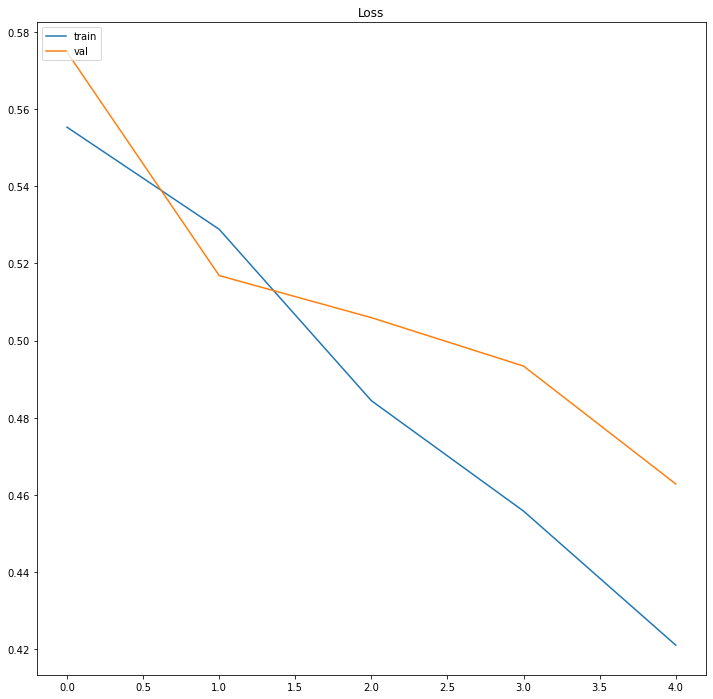

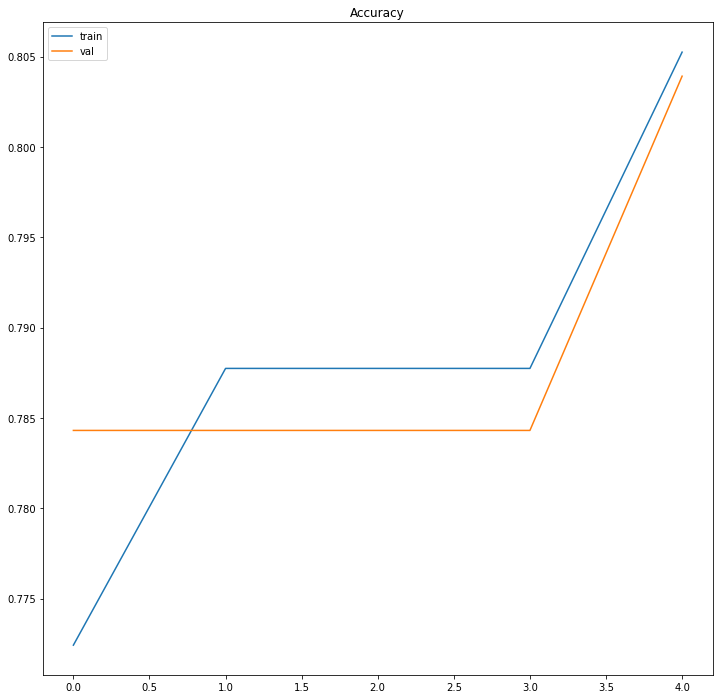

In [37]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix

In [29]:
y_predict = model.predict(x_test, batch_size=None, verbose=0, steps=None)
y_predict

array([[0.53358024],
       [0.33035555],
       [0.4496001 ],
       [0.30885583],
       [0.16532117],
       [0.5718747 ],
       [0.2865519 ],
       [0.37039983],
       [0.31702703],
       [0.5349458 ],
       [0.12650219],
       [0.24978605],
       [0.24302077],
       [0.1739437 ],
       [0.43572003],
       [0.3219939 ],
       [0.50596166],
       [0.3548043 ],
       [0.18578675],
       [0.3612933 ],
       [0.31210688],
       [0.26787287],
       [0.28417522],
       [0.36444798],
       [0.4161817 ],
       [0.5907426 ],
       [0.2333315 ],
       [0.13667586],
       [0.3983823 ],
       [0.32073352],
       [0.05060369],
       [0.37846452],
       [0.1716387 ],
       [0.10891655],
       [0.10688582],
       [0.09170815],
       [0.1202648 ],
       [0.2504556 ],
       [0.33049077],
       [0.33177894],
       [0.28745475],
       [0.20307633],
       [0.04600355],
       [0.15170759],
       [0.30915123],
       [0.33003315],
       [0.32215586],
       [0.213

In [31]:
predict = []
for i in range(len(y_predict)):
    if y_predict[i] > 0.5:
        predict.append(1)
    else:
        predict.append(0)
        
predict

[1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [34]:
# confusion matrix
matrix = confusion_matrix(y_test,predict, labels=[1,0])
print("accuracy score:", accuracy_score(y_test, predict))
print('Confusion matrix : \n',matrix)

NameError: name 'accuracy_score' is not defined

In [35]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,predict,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       1.00      0.19      0.31        27
           0       0.82      1.00      0.90       100

    accuracy                           0.83       127
   macro avg       0.91      0.59      0.61       127
weighted avg       0.86      0.83      0.78       127



In [118]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


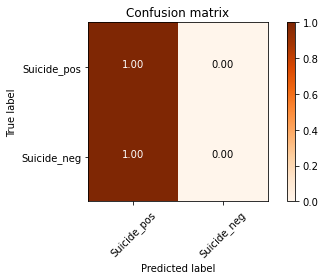

In [119]:
y_pred = predict

#y_pred = convert_to_labels(y_predict)
y_true = y_test
target_names = [ 'Suicide_pos','Suicide_neg']
#print(classification_report(y_true, y_pred, target_names=target_names))

plt.figure()
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True)

plt.show()